In [1]:
# import external libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

#Local PY files
from cleaning_functions import *
from eda import *
from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *


# Configure matplotlib for jupyter.
%matplotlib inline

/home/corey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Imports the dataframes
dffo = pd.read_csv("data/submission_format.csv")
dftr = pd.read_csv("data/training_set_features.csv")
dfte = pd.read_csv("data/test_set_features.csv")
dfla = pd.read_csv("data/training_set_labels.csv")

df = pd.merge(dftr, dfla, on="respondent_id")
df = df.set_index("respondent_id")

In [3]:
#Cleaning steps to do before column names are established.
df = initial_cleaning(df)

#Lists of columns to be fed into the model processor object and the functions that
#manage imputed values for the nans.
binary_columns = ['behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'homeowner']
ordinal_columns = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc']
continuous_columns = ["household_adults", "household_children"]

#Function to generate a dictionary that manages impute strategies depending on
#the type of data.
impute_dict = gen_impute_dict(binary_columns, ordinal_columns, continuous_columns)

#Cleans the rest of the data and stores the fitted imputer objects into a list for later use.
df, imputes = fit_clean_data(df, impute_dict)

In [4]:
df.to_pickle("data.pickle")

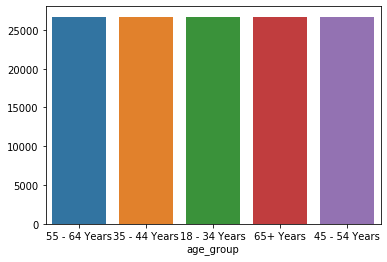

In [5]:
sns.barplot(x=df["age_group"], y=df["age_group"].count())

In [4]:
palette = independant_palette("#ee823e", "#102ca8")

In [ ]:
dynamic_heatmap(df, df.columns.drop(missing_dummies), palette=palette, fontsize=20, annot=.5, figsize=(20,15))

In [7]:
kwargs = {"palette": pal}
graph = Multiplot(df[df.columns.drop(nom.drop(ordinal_columns))], 3, (15,45))
graph.sb_multiplot(sns.boxplot, kwargs)

NameError: name 'pal' is not defined

In [ ]:
df.columns

In [ ]:
sns.swarmplot(x="household_adults", y='seasonal_vaccine', data=df)

In [ ]:
plot_stacked_proportion(df, 'age_group', 'seasonal_vaccine', palette=pal)

In [ ]:
plot_stacked_proportion(df, 'sex', 'seasonal_vaccine')

In [ ]:
df = get_imputer_objs(df, impute_dict, imputes)

In [ ]:
df.columns

In [6]:
#Creating column selection dictionaries for the data from lists of column names.

#Lists to go in the dictionaries.

missing_dummies = extract_column_names(df, "^missing")
target_col1 = "h1n1_vaccine"
target_col2 = "seasonal_vaccine"
target_cols = [target_col1, target_col2]
untr = ['household_adults', 'household_children',]
nom = df.columns.drop([*untr, *binary_columns, *target_cols, *missing_dummies])

#The dicts that come into the arguments.
categorical = {
    "nominal_features":nom, "standard_dummies": binary_columns, "impute_dummies":missing_dummies
}

continuous = {"untransformed":untr}
polynomial = {"method":"choose", "columns":['age_group', 'education', 'sex',
                                            'doctor_recc_seasonal', 'income_poverty']}

In [10]:
data = DataPreprocessor(df, target_col1, categorical, continuous, polynomial, True, True,random_state=124)
data.data_preprocessing(balance_class=False, scale_type=False, poly_degree=2)
data.get_df()
data.column_drop(data.cols_polynomial)
data.column_drop(['age_group_65+ Years education_College Graduate',
       'age_group_65+ Years sex_Male',
       'doctor_recc_seasonal age_group_45 - 54 Years',
       'doctor_recc_seasonal education_Some College',
       'doctor_recc_seasonal income_poverty_unknown',
       'doctor_recc_seasonal sex_Male'], reverse=True)

Creating Dummies
Getting polynomial features of degree 2

['age_group_35 - 44 Years age_group_45 - 54 Years', 'age_group_35 - 44 Years age_group_55 - 64 Years', 'age_group_35 - 44 Years age_group_65+ Years', 'age_group_45 - 54 Years age_group_55 - 64 Years', 'age_group_45 - 54 Years age_group_65+ Years', 'age_group_55 - 64 Years age_group_65+ Years', 'education_< 12 Years education_College Graduate', 'education_< 12 Years education_Some College', 'education_College Graduate education_Some College', 'income_poverty_Above Poverty income_poverty_Below Poverty', 'income_poverty_Above Poverty income_poverty_unknown', 'income_poverty_Below Poverty income_poverty_unknown']
were removed for containing 0 values

Skipping class imbalance functions
No scaling specified
Skipping scaling
Adding ['doctor_recc_seasonal^2', 'doctor_recc_seasonal age_group_35 - 44 Years', 'doctor_recc_seasonal age_group_45 - 54 Years', 'doctor_recc_seasonal age_group_55 - 64 Years', 'doctor_recc_seasonal age_group_65+ 

In [ ]:
data.X_train[data.cols_dummies]

In [ ]:
full_value_counts(df, "h1n1_vaccine")

In [ ]:
forest = RandomForestClassifier(criterion='gini', max_features="auto",
                                random_state=data.random_state, n_jobs=-1,
                                max_depth=9,
                               n_estimators=500)
forest.fit(data.get_X_train(), data.y_train)

In [ ]:
evaluate_model(forest, data.get_X_test(), data.y_test)

In [ ]:
show_feature_importances(forest, data.get_X_test(), figsize=(14, 12), font_scale=1, ascending=True, rows=18)

In [ ]:
df.columns

In [ ]:
chi_squared_loop(df, 'seasonal_vaccine', .01)

In [ ]:
df.columns

In [ ]:
target = 'h1n1_vaccine'
column = 'opinion_seas_sick_from_vacc'

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
(count, nobs, value=None, alternative='two-sided', prop_var=False)[

In [ ]:
import math

    
calc_z_from_proportions(v1, v2, n1, n2)

In [ ]:
df.columns

In [54]:
df.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'homeowner', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine',
       'missing_doctor_recc', 'missing_health_insurance', 'missing_homeowner',
       'missing_household', 'missing_opinion', 'missi

In [63]:
#Creating column selection dictionaries for the data from lists of column names.

#Lists to go in the dictionaries.

missing_dummies = extract_column_names(df, "^missing")
target_col1 = "h1n1_vaccine"
target_col2 = "seasonal_vaccine"
target_cols = [target_col1, target_col2]
untr = ['household_adults', 'household_children',]
nom = df.columns.drop([*untr, *binary_columns, *target_cols, *missing_dummies])

#The dicts that come into the arguments.
categorical = {
    "nominal_features":nom, "standard_dummies": binary_columns, "impute_dummies":missing_dummies
}

continuous = {"untransformed":untr}
polynomial = {"method":"eliminate", "columns":[*missing_dummies, *nom.drop(
    ['age_group', 'education', 'sex'])]}

continuous = {}

categorical = {
    "nominal_features":['age_group', 'income_poverty', 'education', "race", "sex"],
    "standard_dummies":['opinion_seas_vacc_effective', 'doctor_recc_seasonal', 'opinion_seas_risk']
}
polynomial = {"method":"all", "columns":['education', 'sex']}

In [64]:
data = DataPreprocessor(df, target_col2, categorical, continuous, polynomial, True, True,random_state=124)
data.data_preprocessing(balance_class=False, scale_type=None, poly_degree=2)
masked_cols = data.get_X_train().columns.drop(extract_column_names(data.get_X_train(), "\^\d"))

Creating Dummies
Getting polynomial features of degree 2

['age_group_35 - 44 Years age_group_45 - 54 Years', 'age_group_35 - 44 Years age_group_55 - 64 Years', 'age_group_35 - 44 Years age_group_65+ Years', 'age_group_45 - 54 Years age_group_55 - 64 Years', 'age_group_45 - 54 Years age_group_65+ Years', 'age_group_55 - 64 Years age_group_65+ Years', 'income_poverty_Above Poverty income_poverty_Below Poverty', 'income_poverty_Above Poverty income_poverty_unknown', 'income_poverty_Below Poverty income_poverty_unknown', 'education_< 12 Years education_College Graduate', 'education_< 12 Years education_Some College', 'education_College Graduate education_Some College', 'race_Hispanic race_Other or Multiple', 'race_Hispanic race_White', 'race_Other or Multiple race_White']
were removed for containing 0 values

Skipping class imbalance functions
No scaling specified
Skipping scaling


In [65]:
squared_cols = extract_column_names(data.get_X_train(), "\^\d")
masked_cols = data.get_X_train().columns.drop(squared_cols)

corr_cols=correlated_columns_by_threshold(data.get_X_train(), masked_cols, .55)
poly_corr_cols = np.intersect1d(corr_cols, data.cols_polynomial)
data.cols_polynomial.drop([*poly_corr_cols, *squared_cols])
to_drop = np.intersect1d(data.cols_polynomial, [*poly_corr_cols, *squared_cols])
data.column_drop(to_drop)

Adding ['opinion_seas_vacc_effective^2', 'opinion_seas_vacc_effective doctor_recc_seasonal', 'opinion_seas_vacc_effective opinion_seas_risk', 'opinion_seas_vacc_effective age_group_35 - 44 Years', 'opinion_seas_vacc_effective age_group_45 - 54 Years', 'opinion_seas_vacc_effective age_group_55 - 64 Years', 'opinion_seas_vacc_effective age_group_65+ Years', 'opinion_seas_vacc_effective income_poverty_Above Poverty', 'opinion_seas_vacc_effective income_poverty_Below Poverty', 'opinion_seas_vacc_effective income_poverty_unknown', 'opinion_seas_vacc_effective education_< 12 Years', 'opinion_seas_vacc_effective education_College Graduate', 'opinion_seas_vacc_effective education_Some College', 'opinion_seas_vacc_effective race_Hispanic', 'opinion_seas_vacc_effective race_Other or Multiple', 'opinion_seas_vacc_effective race_White', 'opinion_seas_vacc_effective sex_Male', 'doctor_recc_seasonal^2', 'doctor_recc_seasonal opinion_seas_risk', 'doctor_recc_seasonal age_group_55 - 64 Years', 'doctor

In [ ]:
dynamic_heatmap(data.get_df(), masked_cols, fontsize=15, annot=1,
                figsize=(20,15), squaresize=2000, palette=palette)

<Figure size 1440x1080 with 0 Axes>

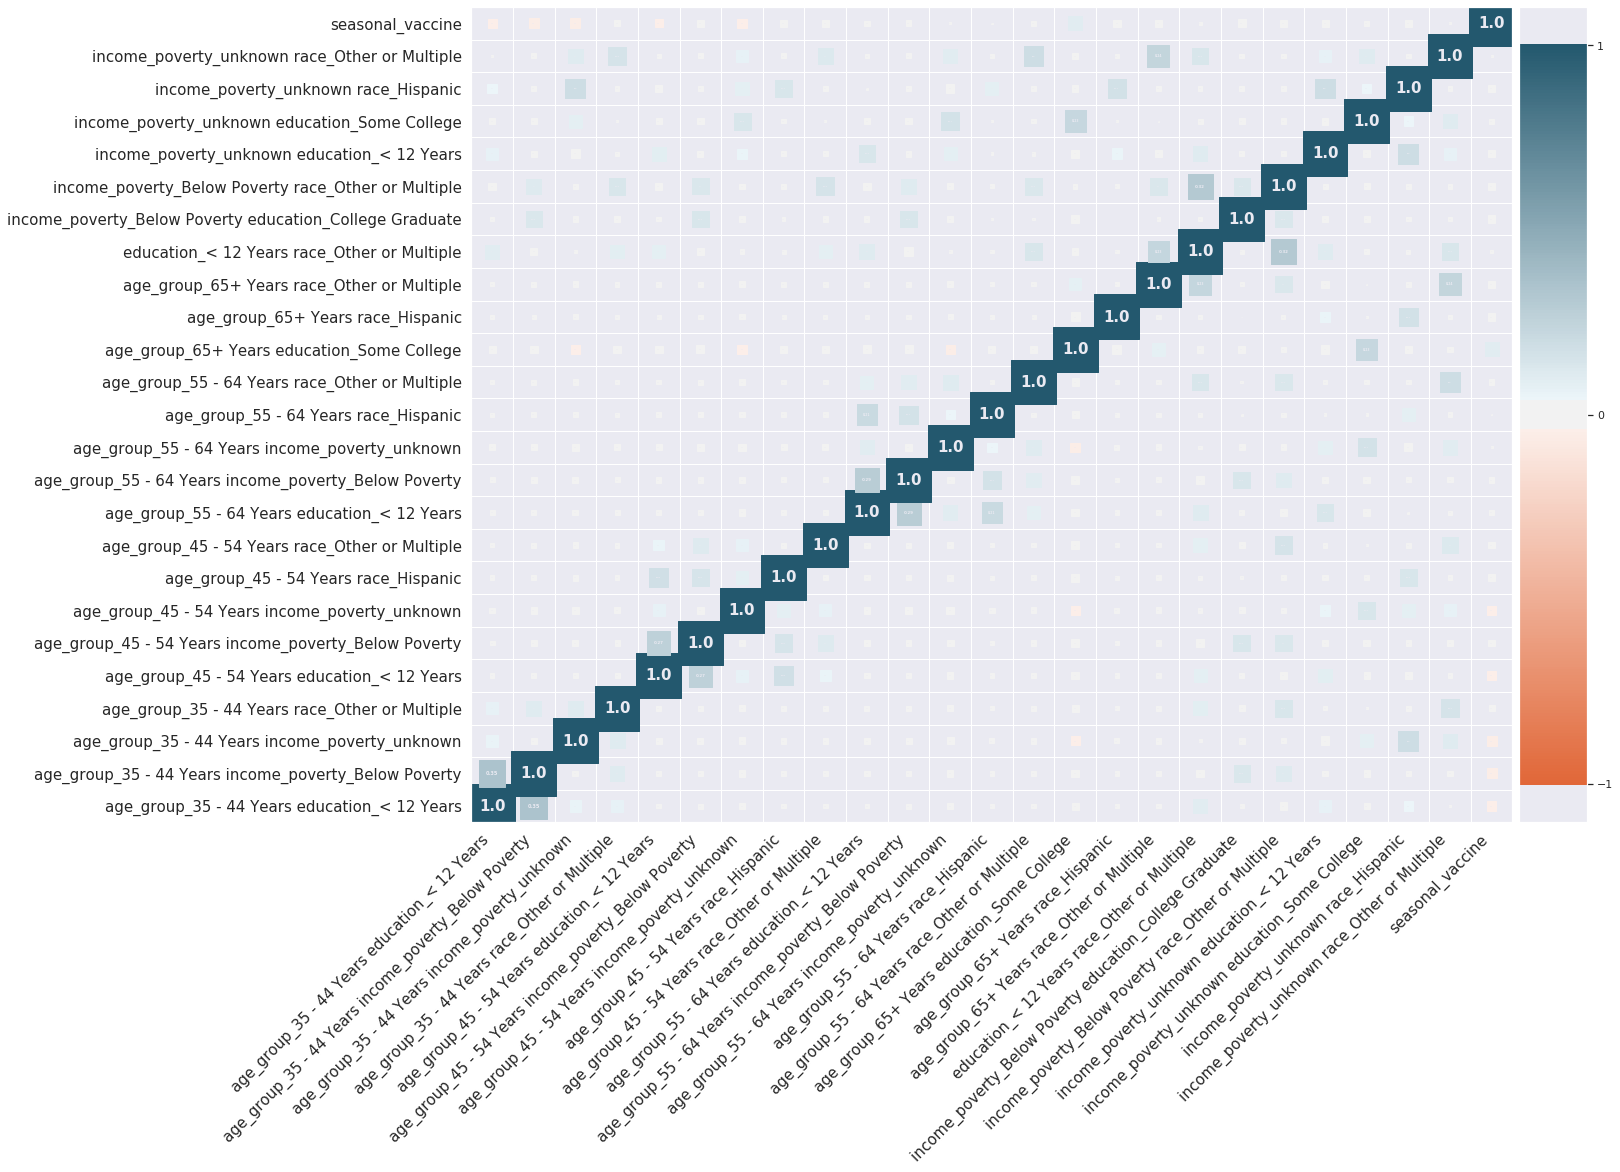

In [58]:
test_cols = data.get_df().columns.drop(data.cols_initial).union(["seasonal_vaccine"])

dynamic_heatmap(data.get_df(), test_cols, fontsize=15, annot=1,
                figsize=(20,15), squaresize=2000, palette=palette)

In [66]:
test_df = data.get_df()[data.get_df().columns.drop(data.cols_initial).union(["seasonal_vaccine"])]

In [89]:
thresh = df_test_threshhold(test_df.corr().tail().T, "seasonal_vaccine", .1)
test_df.corr().tail().T.iloc[:,4][thresh].index.drop("seasonal_vaccine")

Index(['age_group_65+ Years education_College Graduate',
       'age_group_65+ Years sex_Male',
       'doctor_recc_seasonal age_group_45 - 54 Years',
       'doctor_recc_seasonal education_Some College',
       'doctor_recc_seasonal income_poverty_unknown',
       'doctor_recc_seasonal sex_Male'],
      dtype='object')

In [68]:
data.get_df()[data.cols_initial.union(["seasonal_vaccine"])].corr().tail().T.iloc[:,3]

age_group_35 - 44 Years        -0.084788
age_group_45 - 54 Years        -0.063682
age_group_55 - 64 Years         0.046918
age_group_65+ Years             0.244830
doctor_recc_seasonal            0.360696
education_< 12 Years           -0.040238
education_College Graduate      0.053002
education_Some College         -0.016401
income_poverty_Above Poverty    0.021327
income_poverty_Below Poverty   -0.069194
income_poverty_unknown         -0.015425
opinion_seas_risk               0.386916
opinion_seas_vacc_effective     0.358869
race_Hispanic                  -0.066995
race_Other or Multiple         -0.023186
race_White                      0.100314
seasonal_vaccine                1.000000
sex_Male                       -0.077091
Name: seasonal_vaccine, dtype: float64

In [63]:
chi_squared_loop(test_df, "seasonal_vaccine", .001)[1]

seasonal_vaccine                                  0      1
age_group_35 - 44 Years education_< 12 Years              
0.0                                           14084  12372
1.0                                             188     63
seasonal_vaccine                                    0      1
age_group_35 - 44 Years education_Some College              
0.0                                             13652  12121
1.0                                               620    314
seasonal_vaccine                                        0      1
age_group_35 - 44 Years income_poverty_Above Po...              
0.0                                                 13282  11927
1.0                                                   990    508
seasonal_vaccine                                        0      1
age_group_35 - 44 Years income_poverty_Below Po...              
0.0                                                 13994  12337
1.0                                                   278     98


seasonal_vaccine                        0      1
education_< 12 Years race_Hispanic              
0.0                                 13957  12295
1.0                                   315    140
seasonal_vaccine                                 0      1
education_< 12 Years race_Other or Multiple              
0.0                                          14177  12360
1.0                                             95     75
seasonal_vaccine                              0      1
education_College Graduate race_Hispanic              
0.0                                       13967  12245
1.0                                         305    190
seasonal_vaccine                         0      1
education_College Graduate sex_Male              
0.0                                  11687  10070
1.0                                   2585   2365
seasonal_vaccine                          0      1
education_Some College race_Hispanic              
0.0                                   14018  12297

[['age_group_35 - 44 Years education_< 12 Years', 1.1606356685908663e-11],
 ['age_group_35 - 44 Years education_Some College', 9.109650057219355e-16],
 ['age_group_35 - 44 Years income_poverty_Above Poverty',
  7.105688012406462e-24],
 ['age_group_35 - 44 Years income_poverty_Below Poverty',
  1.5546062016662233e-15],
 ['age_group_35 - 44 Years income_poverty_unknown', 1.6652619944673093e-15],
 ['age_group_35 - 44 Years race_Hispanic', 9.616914373508937e-10],
 ['age_group_45 - 54 Years education_< 12 Years', 9.717725404799398e-09],
 ['age_group_45 - 54 Years education_Some College', 5.356720250635673e-08],
 ['age_group_45 - 54 Years income_poverty_Below Poverty',
  0.0005782070998556009],
 ['age_group_45 - 54 Years income_poverty_unknown', 3.0286415506875377e-12],
 ['age_group_45 - 54 Years race_Hispanic', 7.842486478838365e-05],
 ['age_group_45 - 54 Years race_Other or Multiple', 0.0007036174508769015],
 ['age_group_45 - 54 Years sex_Male', 2.7466279185011466e-24],
 ['age_group_55 - 6

In [10]:
calc_chi_squared(df, 'education', 'h1n1_vaccine')

h1n1_vaccine         0     1
education                   
12 Years          4726  1071
< 12 Years        1968   395
College Graduate  8760  2744
Some College      5579  1464


(103.18537711307252,
 3.209804092590849e-22,
 3,
 array([[4565.40611076, 1231.59388924],
        [1860.97199236,  502.02800764],
        [9059.93305126, 2444.06694874],
        [5546.68884562, 1496.31115438]]))

In [11]:
z_test_proportions(df, 'education', 'h1n1_vaccine', 1, .01)

([],
 [['12 Years', 100.34906670488081, 0.0],
  ['< 12 Years', 234.5076640714018, 0.0],
  ['College Graduate', 3.1986773273537508, 0.0013805959761344464],
  ['Some College', 68.63962434888663, 0.0]])

In [ ]:
df["education"]

In [ ]:
unknown_cols = extract_column_names(data.get_df(), "unknown$")
unknown_cols

In [ ]:
dynamic_heatmap(data.get_df(), unknown_cols, fontsize=25, annot=1,
                figsize=(20,15), squaresize=8000)

In [ ]:
df.columns

In [ ]:
'missing_household'